<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-and-preprocessing-data" data-toc-modified-id="Loading-and-preprocessing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading and preprocessing data</a></span></li><li><span><a href="#Machine-learning-part" data-toc-modified-id="Machine-learning-part-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Machine learning part</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

# Determining the level of difficulty of movies for English language learning

Watching movies in their original language is a popular and effective way to improve language skills, but it can be challenging to find movies that are appropriate for a student's level.

**This project aims** to develop a machine learning solution that can automatically determine the difficulty level of English-language movies, making it easier to choose movies that are both interesting and understandable.

The input data consists of a labeled dataset with movie titles, subtitles, and language proficiency level tags (A1/A2/B1/B2/C1/C2). Because of the large number of classes, **the most relevant metric** to use would be F1-score.

## Loading and preprocessing data

In [118]:
# !pip install pysrt
# !pip install nltk
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

In [162]:
# imports
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysrt

import nltk 
from nltk.corpus import stopwords as nltk_stopwords

import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings("ignore")

In [5]:
def load_srt_from_folder(folder):
    """
    Find and load files with .srt extention in the folder.
    """
    
    root_dir = f'English_level/English_scores/Subtitles_all/{folder}/'
    subtitles, movies = [], []
    
    # find all the subtitle files with an .srt extension in root_dir
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".srt"):
                filepath = os.path.join(dirpath, filename)
                movies.append(filename[:-4]) # the movie name
                
                movie_subs = pysrt.open(filepath, encoding='iso-8859-1')
                movie_subs = [sub.text for sub in movie_subs]
                subtitles.append(' '.join(movie_subs))
    
    print(f'Subtitles: {len(subtitles)} files from {folder} loaded.')
    
    # to dataframe
    subtitles_df = pd.DataFrame({'movie': movies,
                                'text': subtitles})
    return subtitles_df

In [6]:
# load data from folders to dataframe
subs_df = pd.DataFrame(columns=['movie', 'text', 'level'])

for level in ['A2', 'B1', 'B2', 'C1']:
    part_subs_df = load_srt_from_folder(level)
    part_subs_df['level'] = level
    
    subs_df = pd.concat([subs_df, part_subs_df])   

Subtitles: 6 files from A2 loaded.
Subtitles: 17 files from B1 loaded.
Subtitles: 107 files from B2 loaded.
Subtitles: 33 files from C1 loaded.


In [7]:
subs_df.head()

,movie,text,level
0,The Walking Dead-S01E01-Days Gone Bye.English,( bugs chittering ) ( brakes squeak ) - ( engi...,A2
1,The Walking Dead-S01E02-Guts.English,- ( birds chirping )\n- ( bugs chittering ) Bo...,A2
2,The Walking Dead-S01E03-Tell It To The Frogs.E...,( thunder rumbling ) Merle:\nThat's right. You...,A2
3,The Walking Dead-S01E04-Vatos.English,( birds chirping ) - What?\n- Nothing. It's no...,A2
4,The Walking Dead-S01E05-Wildfire.English,"- ( walkie-talkie squawks )\n- Rick: Morgan, I...",A2


In [8]:
# also the mixed data present in 'Subtitles' folder
mixed_movies = load_srt_from_folder('Subtitles')

# labels for the movies in excel file
labels = pd.read_excel(r'English_level/English_scores/movies_labels.xlsx')
labels = labels.drop(columns='id').rename(columns={'Movie':'movie', 'Level':'level'})

# join level labels
mixed_movies = mixed_movies.merge(labels, on='movie', how='left')
mixed_movies.head()

Subtitles: 115 files from Subtitles loaded.


,movie,text,level
0,10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz...",B1
1,10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here...",B1
2,Aladdin(1992),"<i>Oh, I come from a land\nFrom a faraway plac...",A2/A2+
3,All_dogs_go_to_heaven(1989),CAPTIONING MADE POSSIBLE BY\nMGM HOME ENTERTAI...,A2/A2+
4,An_American_tail(1986),(INDISTINCT CONVERSATION) (ALL LAUGHING) MAMA:...,A2/A2+


In [9]:
# join last part of movies
subs_df = pd.concat([subs_df, mixed_movies])
print(f'Amount: {subs_df.shape[0]}')

Amount: 282


In [10]:
# duplicates
duplicated_movies = subs_df.loc[subs_df.duplicated(subset=['movie']), 'movie'].to_list()
subs_df[subs_df['movie'].isin(duplicated_movies)]

,movie,text,level
47,Inside_out(2015),Advertise your product or brand here<br/>conta...,B1
48,Inside_out(2015),Advertise your product or brand here<br/>conta...,B1
72,Powder(1995),"EMT 1:\nAll right, people,\nlet's move! Let's ...",B1
73,Powder(1995),"EMT 1:\nAll right, people,\nlet's move! Let's ...",B1
81,The_blind_side(2009),[CROWD CHEERING IN DISTANCE] LElGH ANNE: There...,B2
82,The_blind_side(2009),[CROWD CHEERING IN DISTANCE] LElGH ANNE: There...,B1
104,The_terminal(2004),"<font color=""#D900D9"">(AIRPLANE APPROACHES)</f...",B1
105,The_terminal(2004),"<font color=""#D900D9"">(AIRPLANE APPROACHES)</f...","A2/A2+, B1"


The subtitles texts are also the same. So let's remove the duplicates.

In [11]:
subs_df = subs_df[~subs_df.duplicated(subset='movie')]
subs_df.reset_index(drop=True, inplace=True)

In [12]:
# gaps in level column
subs_df[subs_df['level'].isna()].shape[0]

9

Delete movies without labels.

In [13]:
subs_df = subs_df[~subs_df['level'].isna()]

In [14]:
# unique level values
subs_df['level'].value_counts()

B2            136
B1             51
C1             39
A2/A2+         25
B1, B2          8
A2              6
A2/A2+, B1      4
Name: level, dtype: int64

There are several labels with mixed level values. Let's transform them by choosing an easier level. Then only the 4 most common values will remain.

In [15]:
subs_df['level'] = (subs_df['level']
                    .replace('A2/A2+', 'A2')
                    .replace('A2/A2+, B1', 'A2')
                    .replace('B1, B2', 'B1'))

In [16]:
subs_df['level'].value_counts()

B2    136
B1     59
C1     39
A2     35
Name: level, dtype: int64

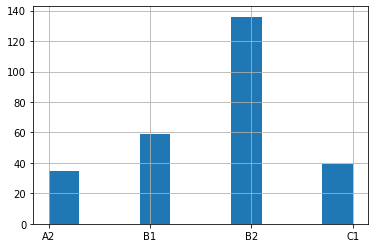

In [163]:
subs_df['level'].hist()
plt.show()

There is a class imbalance. However, the dataset is small so undersampling method can not be used. The oversampling is not better option for NLP tasks.

In [112]:
# example subtitle text
subs_df.loc[20, 'text']

"''Spirit Stallion of the Cimarron'' The story I want to tell you,\ncan not be found in a book. They say the history of the West was\nwritten from the saddle of a horse. But it's never been told\nfrom the heart of one. Not until now. I was born here. In this place that would come\nto be called the ''Old West'' But to my kind, the land was ageless.\nIt had no beginning and no end. No boundary between earth and sky. Like the wind in the Buffalo grass.\nWe belong here. We will always belong here. They say the mustang is the\nspirit of the West. Whether that West\nwas won or lost in the end You have to decide for yourself. But the story\nI want to tell you is true. I was there. And I remember. I remember the sun, and the sky\nand the wind calling my name. In the time when the wild\nhorses ran free. ## Here I am ## This is me ## I come to this world so wild and free ## Here I am ## So young and strong ## Right here in the place where I belong ## It's a new world ## It's a new start ## It's 

Subtitles texts need to be processed before using machine learning. All words need to be converted to lowercase and to normal form. Also punctiation marks, technical messages, comments and stopwords should be removed.

In [105]:
# stopwords for English from nltk
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

# additional stopwords
pronouns = ['I', 'me', 'you', 'he', 'she', 'it']
articles = ['a', 'an', 'the']
prepositions = ['in', 'on', 'at', 'by', 'to', 'for', 'from']
conjunctions = ['and', 'but', 'or', 'yet']
interjections = ['oh', 'shh', 'yeah', 'ah', 'uh', 'mmm']

stopwords = stopwords + pronouns + articles + prepositions + conjunctions + interjections


def clean_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return " ".join(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\veradiss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
# lemmatization
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    
    return lemmas

In [123]:
# regular expressions
HTML = r'<.*?>' # html tags
TAG = r'{.*?}'  # other tags
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]' # comments
UPPER = r'[[A-Za-z ]+[\:\]]'  # speakers names (BOBBY:)
LETTERS = r'[^a-zA-Z\'.,!? ]' # need only the letters 
APOSTROPHES = r' [A-Za-z]+\'[A-Za-z]+ ' # delete words with apostrophes
SPACES = r'([ ])\1+' # multiple spaces
SYMB = r"[^\w\d'\s]" # puctuation marks


def clean_text(text):
    """
    Clean up the text by removing unnecessary elements.
    """    
    # replace with a space
    for element in [HTML, TAG, COMMENTS, UPPER, LETTERS, APOSTROPHES]:
        text = re.sub(element, ' ', text) 
    
    # replace with an empty string
    text = re.sub(SYMB, '', text)
    text = re.sub('www', '', text)
    text = re.sub("''", '', text)
    
    # spaces
    text = re.sub(SPACES, r'\1', text)
    
    # delete non-ascii characters
    text = text.encode('ascii', 'ignore').decode() 
    
    text = text.strip() # delete left and right spaces
    text = text.lower() # lowercase

    return text

In [115]:
# general function, which includes all steps
def prepare_text(text):
    text = clean_text(text)      # delete incorrect characters
    text = lemmatize_text(text)  # lemmatization
    text = clean_stopwords(text) # delete stopwords
    
    return text

In [125]:
%%time

subs_df['prepared_text'] = subs_df['text'].apply(prepare_text)
subs_df.loc[20, 'prepared_text'] # example

CPU times: total: 4min 22s
Wall time: 4min 31s


"spirit stallion cimarron story want tell find book say history west write saddle horse never tell heart one bear place would come call old west kind land ageless beginning end boundary earth sky like wind buffalo grass belong always belong say mustang spirit west whether west win lose end decide story want tell true remember remember sun sky wind call name time wild horse run free come world wild free young strong right place belong new world new start life beating young heart new day new land wait new world new start life beating young heart new day new land wait grow colt stallion wild reckless thunder land race eagle soar wind fly time believe could like father become leader cimarron herd honour come responsibility hear wind across plane sound strong call name wild like river warm like sun belong star sky eagle fly place paradise place call home moon mountain whisper tree wind water let nothing come everything want everything together nothing fear wherever wander one thing learn ye

## Machine learning part
Let's try to apply the SGD algorithm for the task.

In [127]:
X = subs_df['prepared_text'] # texts
y = subs_df['level']         # target

In [152]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, stratify=y, random_state = 123)

X_train.shape[0], X_test.shape[0]

(201, 68)

In [153]:
# pipeline
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=123))
])

In [157]:
%%time

# parameters for GridSearchCV
params = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'clf__loss': ['hinge', 'log'],      
    'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
    'clf__penalty': ['l2', 'l1', 'elasticnet'],
    'clf__learning_rate': ['constant', 'optimal', 'invscaling'],
    'clf__eta0': [0.1, 0.01, 0.001]
}

grid = GridSearchCV(pipe, params, scoring='f1_macro', cv=5, n_jobs=4, verbose=1)
grid.fit(X_train, y_train)

print("Best parameters: {}".format(grid.best_params_))
print("Best score: {}".format(grid.best_score_))
print("Times info:")
display(pd.DataFrame(grid.cv_results_).query('rank_test_score == 1')[['mean_fit_time', 'mean_score_time']])

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters: {'clf__alpha': 0.0001, 'clf__eta0': 0.1, 'clf__learning_rate': 'optimal', 'clf__loss': 'hinge', 'clf__penalty': 'l2', 'vect__max_df': 0.5}
Best score: 0.622448989321445
Times info:


,mean_fit_time,mean_score_time
18,0.658294,0.153460
72,0.803289,0.202004
126,0.689289,0.152328


CPU times: total: 16.1 s
Wall time: 15min 54s


In [160]:
# final testing
pipe_final = Pipeline([
    ('vect', CountVectorizer(max_df=0.5)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', 
                          alpha=0.0001, 
                          penalty='l2', 
                          learning_rate='optimal',
                          eta0=0.1,
                          random_state=123))
])

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)
f1 = f1_score(y_test, predictions, average='macro')
print(f'F1 score for test set: {round(f1, 3)}')

F1 score for test set: 0.624


## Results

The aim of this project was to develop a machine learning solution for determining the level of difficulty of English movies. *The SGDClassifier* algorithm was choosed. **The best achieved f1_score of 0.624**.

To achieve this result, the text data was first preprocessed by removing unnecessary fragments and stopwords, lemmatizing the words, and also transforming the text into numerical features using *the CountVectorizer* and *TfidfTransformer*. Then the SGDClassifier algorithm was used with *GridSearchCV* to optimize the hyperparameters.

Overall, the results of the project showed that machine learning algorithms can be effective in determining the level of difficulty of movies for English language learners. However, there is still room for improvement in terms of accuracy and further experimentation with different algorithms and preprocessing techniques.